In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score
from collections import Counter


In [55]:

train_dir = r'/Users/minhquan/Desktop/ChestCT_Classification-main/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (150, 150),
    batch_size = 32,
    label_mode = 'categorical'
)

val_dir = r'/Users/minhquan/Desktop/ChestCT_Classification-main/valid'
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)

test_dir = r'/Users/minhquan/Desktop/ChestCT_Classification-main/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)



Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [56]:
class_counts = Counter()
for images, labels in train_dataset:
    # Convert one-hot encoded labels to class indices
    class_indices = np.argmax(labels.numpy(), axis=1)
    class_counts.update(class_indices)

# Print the counts for each class
print("Number of images per class:")
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} images")

Number of images per class:
Class 1: 115 images
Class 0: 195 images
Class 3: 155 images
Class 2: 148 images


2024-10-03 21:43:29.831431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [57]:
# Class name
class_name = train_dataset.class_names
print(class_name)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [58]:
''' preprocess '''

'''Normalization'''
# Create normalization layer that rescale pixel values from [0,255] to [0,1]
normalization_layer = layers.Rescaling(1./255)


# Apply the normalization layer to the dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

'''Augumentation (just do it slightly, as the medical ct is sensitive, hence, the augmentations should preserve the medical features and the structural integrity of the images)'''


# Data augmentation (minimal augmentation)
data_augmentation = tf.keras.Sequential(
    [
        # Randomly adjust the contrast of the image. 
        layers.RandomContrast(factor=(0.9, 1.1)),
        # Randomly translate (shift) the image along the height and width.
        layers.RandomTranslation(height_factor=0.1, width_factor=0.05),
        
    ]
)

# Apply the augmentation to the training dataset and validation dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
validation_dataset_dataset = validation_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))







In [59]:
''' Build CNN model'''
# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # Change 3 to the number of your classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'binary_crossentropy' for 2 classes
              metrics=['accuracy'])

# Summary of the model
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5  # Adjust the number of epochs based on your data
)


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 689ms/step - accuracy: 0.3040 - loss: 1.8823 - val_accuracy: 0.4306 - val_loss: 1.4570
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - accuracy: 0.4290 - loss: 1.2640 - val_accuracy: 0.4306 - val_loss: 1.1762
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 687ms/step - accuracy: 0.4903 - loss: 1.1779 - val_accuracy: 0.5139 - val_loss: 1.1593
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 699ms/step - accuracy: 0.4701 - loss: 1.1462 - val_accuracy: 0.4861 - val_loss: 1.0769
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 593ms/step - accuracy: 0.5639 - loss: 1.0045 - val_accuracy: 0.5972 - val_loss: 1.0111


In [61]:
''' Evaluate the model'''
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5994 - loss: 1.0263
Validation Accuracy: 0.5972222089767456


In [74]:
# Get predictions on the validation set
predictions = model.predict(validation_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
true_classes = np.argmax(true_labels, axis=1)





3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


2024-10-03 21:46:51.820519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


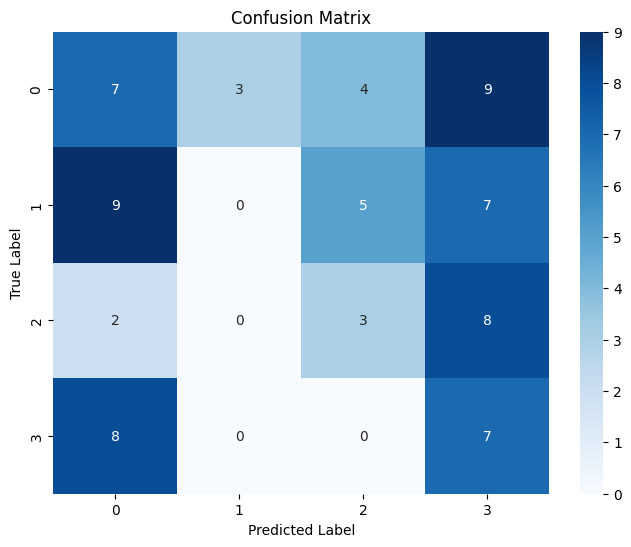

In [75]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)


# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [64]:

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision (macro-averaged across all classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
print(f"Precision (macro): {precision:.4f}")

# Compute recall (macro-averaged across all classes)
recall = recall_score(true_classes, predicted_classes, average='macro')
print(f"Recall (macro): {recall:.4f}")

# Compute F1-score (macro-averaged across all classes)
f1 = f1_score(true_classes, predicted_classes, average='macro')
print(f"F1-Score (macro): {f1:.4f}")





Accuracy: 0.2500
Precision (macro): 0.1862
Recall (macro): 0.2472
F1-Score (macro): 0.2073
